# Convolution based time series classification in aeon

This notebook is a high level introduction to using and configuring convolution based
classifiers in aeon. Convolution based classifiers are based on the ROCKET transform
[1] and the subsequent extensions MiniROCKET [2], MultiROCKET [3], HYDRA [4] 
a combination of ROCKET and HYDRA. These
transforms can be used in pipelines, but we provide convolution based classifiers
 based on ROCKET variants for ease of use and reproducibility. These are the 
 RocketClassifier, MiniRocketClassifier, MultiRocketClassifier, MultiRocketHydraClassifier [4] and an ensemble of 
ROCKET classifiers called the Arsenal. The RocketClassifier 
 combines the ROCKET transform with a scikit-learn RidgeClassifierCV classifier, while 
 Hydra and MultiRocketHydra further extend this approach by enhancing feature 
 extraction and handling multiple feature maps more effectively.The term
 convolution and kernel are  used interchangably in this notebook. A convolution is a
  subseries that is used to create features for a time series. To do this, a
  convolution is run along a series, and the dot product is calculated. This creates a
   new series (often called an activation map or feature map) where large values
   correspond to a close correlation to the convolution.

<img src="./img/convolution.png" width="600" alt="Windowing.">

ROCKET computes two features from the resulting feature maps: the maximum value
(sometimes called a max pooling operation), and the proportion of positive values (or
 ppv). In the above example the first entry of the activation map is the result of a
 dot-product between $T_{1:3} * \omega = T_{1:3} \cdot \omega = 0 + 0 + 3 = 3$. Max
 pooling extracts the maximum from the activation map as feature. The proportion of
 positive values (PPV) is $8 / 11$ in this example.

A large number of random convolutions are generated, and the two features are
combined to produce a transformed train data set. This is used to train a linear
classifier. [1] reccomend a RIDGE Regression Classifier using cross-validation to
train the $L_2$-regularisation parameter $\alpha$. A logistic regression classifier
is suggested as a replacement for larger datasets.
<img src="./img/rocket2.png" width="600" alt="ROCKET.">

ROCKET employs dilation. Dilation is a form of down sampling, in that it defines
spaces between time points. Hence, a convolution with dilation $d$ is compared to
time points $d$ steps apart when calculating the distance.

In [1]:
import warnings

from aeon.utils.discovery import all_estimators

warnings.filterwarnings("ignore")
all_estimators("classifier", tag_filter={"algorithm_type": "convolution"})

[('Arsenal', aeon.classification.convolution_based._arsenal.Arsenal),
 ('HydraClassifier',
  aeon.classification.convolution_based._hydra.HydraClassifier),
 ('MiniRocketClassifier',
  aeon.classification.convolution_based._minirocket.MiniRocketClassifier),
 ('MultiRocketClassifier',
  aeon.classification.convolution_based._multirocket.MultiRocketClassifier),
 ('MultiRocketHydraClassifier',
  aeon.classification.convolution_based._mr_hydra.MultiRocketHydraClassifier),
 ('RocketClassifier',
  aeon.classification.convolution_based._rocket.RocketClassifier)]

In [2]:
from sklearn.metrics import accuracy_score

from aeon.classification.convolution_based import (
    Arsenal,
    HydraClassifier,
    MiniRocketClassifier,
    MultiRocketClassifier,
    MultiRocketHydraClassifier,
    RocketClassifier,
)
from aeon.datasets import load_basic_motions  # multivariate dataset
from aeon.datasets import load_italy_power_demand  # univariate dataset

italy, italy_labels = load_italy_power_demand(split="train")
italy_test, italy_test_labels = load_italy_power_demand(split="test")
motions, motions_labels = load_basic_motions(split="train")
motions_test, motions_test_labels = load_basic_motions(split="test")
italy.shape

(67, 1, 24)

The ROCKET transform compiles on import via ``numba``, which may take a few seconds. 
``RocketClassifier`` does not produce estimates of class probabilities. Because of this, 
the Arsenal was developed to use with the HIVE-COTE meta-ensemble (in the hybrid 
package). The Arsenal is an
ensemble of ``RocketClassifier`` estimators that is no more accurate than 
``RocketClassifier``, but gives better probability estimates.

<img src="./img/rocket.png" width="600" alt="Rocket overview.">


In [3]:
rocket = RocketClassifier()
rocket.fit(italy, italy_labels)
y_pred = rocket.predict(italy_test)
accuracy_score(italy_test_labels, y_pred)

0.9708454810495627

In [4]:
afc = Arsenal()
afc.fit(italy, italy_labels)
y_pred = afc.predict(italy_test)
accuracy_score(italy_test_labels, y_pred)

0.967930029154519

The ``MiniRocketClassifier`` [2] uses the ``MiniRocket`` transform a fast version of 
``Rocket`` that uses hard coded convolutions and only uses PPV. MultiROCKET [3] 
adds three new pooling operations extracted from each
 kernel: mean of positive values (MPV), mean of indices of positive values (MIPV) and
  longest stretch of positive values (LSPV). ``MultiRocket`` generates a total of 50k
  features from 10k kernels and 5 pooling operations. It also extracts features from
  first order differences. There are separate classifiers for ``MiniRocket`` and
  ``MultiRocket``. The ``Arsenal`` can be configured to use
  the ``MiniRocket`` or ``MultiRocket`` by setting the ``rocket_transform`` parameter to
  "minirocket" or "multirocket". Both work on multivariate series.

In [5]:
multi_arsenal = Arsenal(rocket_transform="multirocket")
multi_arsenal.fit(italy, italy_labels)
y_pred = multi_arsenal.predict(italy_test)
accuracy_score(italy_test_labels, y_pred)

0.9698736637512148

In [6]:
mini_r = MiniRocketClassifier(num_kernels=100)
multi_r = MultiRocketClassifier(num_kernels=100)
mini_r.fit(motions, motions_labels)
y_pred = mini_r.predict(motions_test)
print(" mini acc =", accuracy_score(motions_test_labels, y_pred))
multi_r.fit(motions, motions_labels)
y_pred = multi_r.predict(motions_test)
print(" multi acc =", accuracy_score(motions_test_labels, y_pred))

 mini acc = 1.0
 multi acc = 1.0


The HYDRA transform [4] (for HYbrid Dictionary-Rocket Architecture) is a dictionary 
method for time series classification using competing convolutional kernels, incorporating aspects 
of both Rocket and conventional dictionary methods. Hydra involves transforming 
the input time series using a set of random convolutional kernels, arranged into `g`
groups with `k` kernels per group, and then at each timepoint counting the kernels 
representing the closest match with the input time series for each group.

In [7]:
hydra_clf = HydraClassifier()
hydra_clf.fit(italy, italy_labels)
y_pred = hydra_clf.predict(italy_test)
accuracy_score(italy_test_labels, y_pred)

0.966958211856171

``MultiRocketHydra`` concatenates the results of the ``Hydra`` and ``MultiRocket`` 
transform and trains RidgeClassifierCV on the combined features.

In [8]:
mr_hydra = MultiRocketHydraClassifier()
mr_hydra.fit(italy, italy_labels)
y_pred = mr_hydra.predict(italy_test)
accuracy_score(italy_test_labels, y_pred)

0.9689018464528668

Convolutional classifiers have three other parameters that may affect performance.
`num_kernels` (default 10,000) determines the number of convolutions/kernels generated
 and will influence the memory usage. `max_dilations_per_kernel` (default=32) and
`n_features_per_kernel` (default=4) are used in 'MiniROCKET' and 'MultiROCKET'. For
each candidate convolution, `max_dilations_per_kernel` are assessed and
`n_features_per_kernel` are retained.


## Performance on the UCR univariate datasets

You can find the convolution based classifiers as follows

In [9]:
from aeon.utils.discovery import all_estimators

est = all_estimators("classifier", tag_filter={"algorithm_type": "convolution"})
for c in est:
    print(c)

('Arsenal', <class 'aeon.classification.convolution_based._arsenal.Arsenal'>)
('HydraClassifier', <class 'aeon.classification.convolution_based._hydra.HydraClassifier'>)
('MiniRocketClassifier', <class 'aeon.classification.convolution_based._minirocket.MiniRocketClassifier'>)
('MultiRocketClassifier', <class 'aeon.classification.convolution_based._multirocket.MultiRocketClassifier'>)
('MultiRocketHydraClassifier', <class 'aeon.classification.convolution_based._mr_hydra.MultiRocketHydraClassifier'>)
('RocketClassifier', <class 'aeon.classification.convolution_based._rocket.RocketClassifier'>)


We can recover the results and compare the classifier performance as follows:


In [10]:
from aeon.benchmarking.results_loaders import get_estimator_results_as_array
from aeon.datasets.tsc_datasets import univariate

names = [t[0].replace("Classifier", "") for t in est]
names.append("MiniROCKET")  # Alternatve configuration of the RocketClassifier
results, present_names = get_estimator_results_as_array(
    names, univariate, include_missing=False
)
results.shape

(112, 7)

(<Figure size 600x260 with 1 Axes>, <Axes: >)

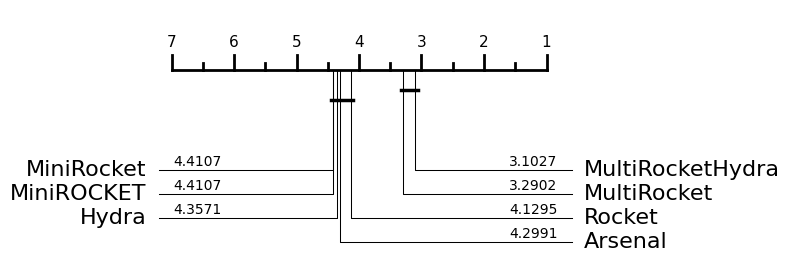

In [11]:
from aeon.visualisation import plot_boxplot, plot_critical_difference

plot_critical_difference(results, names)

(<Figure size 1000x600 with 1 Axes>, <Axes: >)

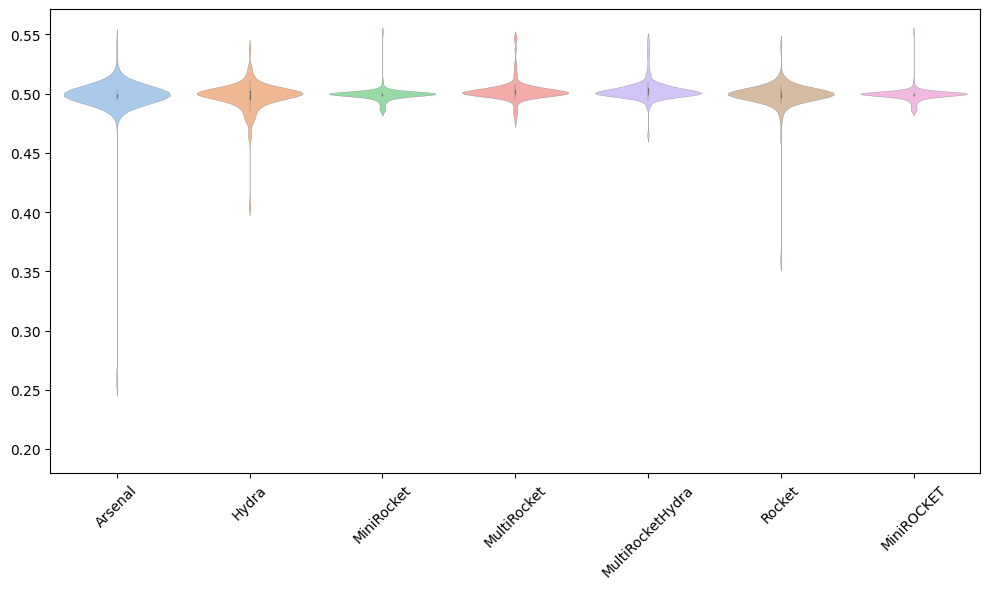

In [12]:
plot_boxplot(results, names, relative=True)

## References

[1] Dempster A, Petitjean F and Webb GI (2019) ROCKET: Exceptionally fast
and accurate time series classification using random convolutional kernels.
[arXiv:1910.13051](https://arxiv.org/abs/1910.13051),
[Journal Paper](https://link.springer.com/article/10.1007/s10618-020-00701-z)

[2]  Dempster A, Schmidt D and Webb G (2021) MINIROCKET: A Very Fast (Almost)
Deterministic Transform for Time Series Classification
[arXiv:2012.08791](https://arxiv.org/abs/2012.08791)
[Conference Paper](https://dl.acm.org/doi/abs/10.1145/3447548.3467231)

[3] Cahng Wei T, Dempster A, Bergmeir C and Webb G (2022) MultiRocket: multiple pooling
operators and transformations for fast and effective time series classification
[Journal Paper](https://link.springer.com/article/10.1007/s10618-022-00844-1)

[4] Dempster, A., Schmidt, D.F. and Webb, G.I. (2023) Hydra: Competing convolutional 
kernels for fast and accurate time series classification.
[arXiv:2203.13652](https://arxiv.org/abs/2203.13652),
[Journal Paper](https://link.springer.com/article/10.1007/s10618-023-00939-3)
